# **Introduction:**
### **a) Defining problem statement**
The objective of the project is to explore the dataset for RSNA Pneumonia Detection to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, the algorithm needs to automatically locate lung opacities on chest radiographs.

We start by exploring the DICOM data, we extract the meta information from the DICOM files and visualize the various features of the DICOM images, grouped by age, sex.

We will use data from URL: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

### **b) Need of the study/project**
Diagnosing pneumonia requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. 

CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis.

### **c) Understanding business/social opportunity**
Automating Pneumonia screening in chest radiographs, providing affected area details through a bounding box. Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (ex. radiology). Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making...



In [2]:
!pip install -q pydicom 
!pip install -q tqdm 
!pip install -q imgaug 

In [117]:
import os
#### code added below ####
os.chdir('/kaggle/input/rsna-pneumonia-detection-challenge')

In [8]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline
import pydicom
import pydicom as dcm
#from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
import random
import math
import cv2
import json
from imgaug import augmenters as iaa
import glob 
from skimage import measure
from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

In [0]:
#%tensorflow_version 1.x
#import tensorflow as tf
#print(tf.__version__)

**Project Note 1**

In [9]:
class_info_df = pd.read_csv('stage_2_detailed_class_info.csv')
train_lables_df = pd.read_csv('stage_2_train_labels.csv')

In [10]:
class_info_df.shape, train_lables_df.shape

((30227, 2), (30227, 6))

**Lets explore the data**

In [11]:
class_info_df.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

Class info data given detailed information about patient and the associated classes.

In [12]:
train_lables_df.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

Train Lable dataset given information about the patient and the traget meta data info.

In [13]:
class_info_df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

Image Class dataset contains 3 different classes which are No Lung Opacity / Not Normal, Lung Opacity and Normal. And we can see the data is not equally distributed. So it may impact the model prediction.

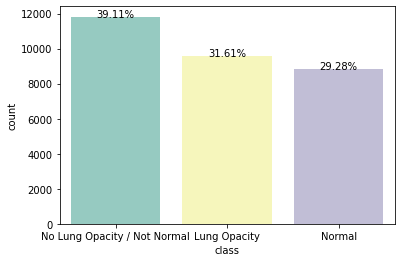

In [14]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [15]:
train_lables_df['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

We can see Traget values also not equally distributed.

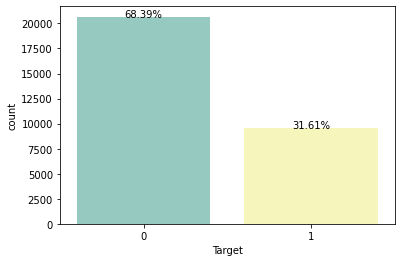

In [16]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(train_lables_df))
sns.countplot(train_lables_df['Target'],order = train_lables_df['Target'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

**Lets find duplicate data**

In [17]:
duplicate_class_info = class_info_df['patientId'].duplicated(keep=False)
print("Any duplicate data in class_info_df::",duplicate_class_info.any())
if duplicate_class_info.any():
    print(class_info_df[duplicate_class_info])

Any duplicate data in class_info_df:: True
                                  patientId         class
4      00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
5      00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
8      00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity
9      00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity
14     00aecb01-a116-45a2-956c-08d2fa55433f  Lung Opacity
...                                     ...           ...
30220  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2  Lung Opacity
30221  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  Lung Opacity
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  Lung Opacity
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity

[6941 rows x 2 columns]


We can see total 6941 patient duplicate rows observed from class information dataset.

In [18]:
class_info_df[duplicate_class_info]['class'].value_counts()

Lung Opacity    6941
Name: class, dtype: int64

In [19]:
duplicate_train_lables = train_lables_df['patientId'].duplicated(keep=False)
print("Any duplicate data in train_lables_df::",duplicate_train_lables.any())
if duplicate_train_lables.any():
    print(train_lables_df[duplicate_train_lables])

Any duplicate data in train_lables_df:: True
                                  patientId      x      y  width  height  \
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
5      00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0   
8      00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0   
9      00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0   
14     00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0   
...                                     ...    ...    ...    ...     ...   
30220  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2  316.0  504.0  179.0   273.0   
30221  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  609.0  464.0  240.0   284.0   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  
4           1  
5         

We can see duplicate entries in train lable dataset as well.

In [20]:
train_lables_df[duplicate_train_lables]['Target'].value_counts()

1    6941
Name: Target, dtype: int64

In [21]:
train_lables_df[train_lables_df['patientId'] == 'c1f7889a-9ea9-4acb-b64c-b737c929599a']

patientId      x      y  width  height  \
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  
30225       1  
30226       1

In [22]:
class_info_df[class_info_df['patientId'] == 'c1f7889a-9ea9-4acb-b64c-b737c929599a']

patientId         class
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity

In [23]:
class_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
patientId    30227 non-null object
class        30227 non-null object
dtypes: object(2)
memory usage: 472.4+ KB


In [24]:
train_lables_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
patientId    30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


Lets check those duplicate entries for both class info and Lable info datasets are same or not.

In [25]:
c1 = pd.DataFrame(class_info_df[duplicate_class_info]['patientId'])
t2 = pd.DataFrame(train_lables_df[duplicate_train_lables]['patientId'])
c1['patientIdMatch'] = np.where(class_info_df[duplicate_class_info]['patientId'] == train_lables_df[duplicate_train_lables]['patientId'], 'True', 'False') 

In [26]:
c1['patientIdMatch'].value_counts()

True    6941
Name: patientIdMatch, dtype: int64

In [27]:
print("Unique patientId in  class_info_df: ", class_info_df['patientId'].nunique()) 
print("Unique patientId in  train_lables_df: ", train_lables_df['patientId'].nunique())

Unique patientId in  class_info_df:  26684
Unique patientId in  train_lables_df:  26684


**We can see both class information and label information data has duplicate entries for some patientId's (I can say its for same patientId's) with Target value 1 or class Lung Opacity which we need to treat further. To treat these duplicate value we need more information from DICOM IMAGES which we use to select which entries we can keep for each unique patient ID's. So lets see image data and check is there any duplicate images found which we can use to treat this duplicate patient infomation**

In [28]:
PATH = "/kaggle/input/rsna-pneumonia-detection-challenge/"
image_train_path = os.listdir(PATH+'stage_2_train_images/')
image_test_path = os.listdir(PATH+'stage_2_test_images/')
print("Number of images in train set:", len(image_train_path))
print("Number of images in test set:", len(image_test_path))

Number of images in train set: 26684
Number of images in test set: 3000


**Lets find any duplicate images found for any patients**

In [29]:
set([x for x in image_train_path if image_train_path.count(x) > 1])

set()

In [30]:
set([x for x in image_test_path if image_test_path.count(x) > 1])

set()

**We can notice that there is no duplicate images found and also number of train images present are equal with unique patient information in class_info_df and train_lables_df i.e 26684.** 

**There is no seperate images for each duplicated patient ID information from class_info_df and train_lables_df datasets. So we can safely remove any of the duplicated columns from both class_info_df and train_lables_df datasets. Its upto you which entry you can keep like first or last occured entry. I assuming that last entry is the latest entry for each duplicated patient ID so will go with Keep last option.**

Lets merge both datasets using Patient ID as the merge criteria

In [31]:
s1 = pd.DataFrame(class_info_df['patientId'])
s2 = pd.DataFrame(train_lables_df['patientId'])

In [32]:
s1['patientIdMatch'] = np.where(s1['patientId'] == s2['patientId'], 'True', 'False') 

In [33]:
s1['patientIdMatch'].value_counts()

True    30227
Name: patientIdMatch, dtype: int64

In [34]:
s1.loc[s1['patientIdMatch'] == 'False']

Empty DataFrame
Columns: [patientId, patientIdMatch]
Index: []

In [35]:
#train_class_df = train_lables_df.merge(class_info_df, on='patientId', how='inner')
train_class_df = pd.merge(class_info_df, train_lables_df, how='inner', on='patientId')

In [36]:
train_class_df.shape

(37629, 7)

**We can see the count after merge, there are some more duplicate entries are added, what are those extra content added now ? Lets explore before droping duplicate entries...**

In [37]:
train_class_df.head()

patientId                         class      x  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal    NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal    NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal    NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal    NaN   
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  264.0   

       y  width  height  Target  
0    NaN    NaN     NaN       0  
1    NaN    NaN     NaN       0  
2    NaN    NaN     NaN       0  
3    NaN    NaN     NaN       0  
4  152.0  213.0   379.0       1

In [38]:
duplicate_train_class_df = train_class_df['patientId'].duplicated(keep=False)
print("Any duplicate data in train_class_df::",duplicate_train_class_df.any())
if duplicate_train_class_df.any():
    print(train_class_df[duplicate_train_class_df])

Any duplicate data in train_class_df:: True
                                  patientId         class      x      y  \
4      00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity  264.0  152.0   
5      00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity  562.0  152.0   
6      00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity  264.0  152.0   
7      00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity  562.0  152.0   
10     00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity  323.0  577.0   
...                                     ...           ...    ...    ...   
37622  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  Lung Opacity  185.0  298.0   
37625  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  570.0  393.0   
37626  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  233.0  424.0   
37627  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  570.0  393.0   
37628  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  233.0  424.0   

       width  height  Target  
4      213.0   379.0    

In [39]:
train_class_df[train_class_df['patientId'] == 'c1f7889a-9ea9-4acb-b64c-b737c929599a']

patientId         class      x      y  \
37625  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  570.0  393.0   
37626  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  233.0  424.0   
37627  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  570.0  393.0   
37628  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  233.0  424.0   

       width  height  Target  
37625  261.0   345.0       1  
37626  201.0   356.0       1  
37627  261.0   345.0       1  
37628  201.0   356.0       1

In [40]:
class_info_df[class_info_df['patientId'] == 'c1f7889a-9ea9-4acb-b64c-b737c929599a']

patientId         class
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity

In [41]:
train_lables_df[train_lables_df['patientId'] == 'c1f7889a-9ea9-4acb-b64c-b737c929599a']

patientId      x      y  width  height  \
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  
30225       1  
30226       1

**We can see for example for patient ID "c1f7889a-9ea9-4acb-b64c-b737c929599a" class_info_df has 2 entries and train_lables_df has 2 entries and merge statement added 4 entries into merged dataset. So lets try another approach to merge the datasets with out these extra unwanted new duplicate records.**

In [42]:
del train_class_df

In [43]:
class_info_df['g'] = class_info_df.groupby('patientId').cumcount()
train_lables_df['g'] = train_lables_df.groupby('patientId').cumcount()
train_class_df = pd.merge(class_info_df,train_lables_df,on=["patientId", 'g'],how='outer').drop('g', axis=1)

In [44]:
train_class_df.shape

(30227, 7)

Now the merged dataset account matched with original data sets.

In [45]:
train_class_df.count()

patientId    30227
class        30227
x             9555
y             9555
width         9555
height        9555
Target       30227
dtype: int64

In [46]:
train_class_df.head()

patientId                         class      x  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal    NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal    NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal    NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal    NaN   
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  264.0   

       y  width  height  Target  
0    NaN    NaN     NaN       0  
1    NaN    NaN     NaN       0  
2    NaN    NaN     NaN       0  
3    NaN    NaN     NaN       0  
4  152.0  213.0   379.0       1

**We can see now the merge dataset count matching count of source datasets. Lets explore some sample data from the merged dataset to confirm the data merged correctly.**

In [47]:
train_class_df[train_class_df['patientId'] == 'c1f7889a-9ea9-4acb-b64c-b737c929599a']

patientId         class      x      y  \
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  570.0  393.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  233.0  424.0   

       width  height  Target  
30225  261.0   345.0       1  
30226  201.0   356.0       1

**Lets check missing data**

In [48]:
df_NAN = train_class_df[train_class_df.isnull().any(axis=1)]

In [49]:
df_NAN.isnull().sum().sort_values(ascending=False)

height       20672
width        20672
y            20672
x            20672
Target           0
class            0
patientId        0
dtype: int64

In [50]:
df_NAN['Target'].value_counts()

0    20672
Name: Target, dtype: int64

**We can see NaN values are found with columns columns are x, y , height, width and only for the cases where Target value as 0 which means Target value 1 cases does not have any NaN values which is a positive information.**

**I am going to replace all NaN values with default zero value as x, y , height, width columns for Target 0 cases i will not be useful. As image predections we focus on images and the Targets only.**

In [51]:
train_class_df.fillna(0, inplace=True)

**From the original datasets we have observed that there are duplicate entires for some of the patient ID's but there are no extra images to match these duplicate patient data so we need drop those duplicate entries.**

**But i observed that from label information bouding box information data is different for each duplicated patient ID's. So lets create a copy of dataset to see the bouding box mask information for such duplicated dataset.**

**Finally we can remove duplicated data so that we can use this data for model train and to get better accuracy. so i will maintain 2 datsets one with duplicate patientID's with different bouding boxes and other one with out any duplicate information. So lets proceed**

In [52]:
#Lets create a 2 datasets
train_class_df1 = train_class_df.copy()

In [53]:
train_class_df1.shape # dataset used to see the multiple bounding box mask information on images.

(30227, 7)

In [54]:
train_class_df1.head()

patientId                         class      x  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal    0.0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal    0.0   
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal    0.0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal    0.0   
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  264.0   

       y  width  height  Target  
0    0.0    0.0     0.0       0  
1    0.0    0.0     0.0       0  
2    0.0    0.0     0.0       0  
3    0.0    0.0     0.0       0  
4  152.0  213.0   379.0       1

In [55]:
train_class_df1[train_class_df1['patientId'] == 'c1f7889a-9ea9-4acb-b64c-b737c929599a']

patientId         class      x      y  \
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  570.0  393.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  233.0  424.0   

       width  height  Target  
30225  261.0   345.0       1  
30226  201.0   356.0       1

In [56]:
#Lets drop duplicate entries from original dataset which we further used for model predection.
train_class_df.drop_duplicates()
train_class_df.drop_duplicates(subset ="patientId", 
                     keep = "last", inplace = True) 

In [57]:
train_class_df.shape # Final data set which used for model train

(26684, 7)

**Now all duplicated entries are dropped and i have a dataset with unique patient ID's matching with images data.**

In [58]:
train_class_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

class  Target  Patient Count
0                  Lung Opacity       1           6012
1  No Lung Opacity / Not Normal       0          11821
2                        Normal       0           8851

Lets Plot visually class and Target Distribution

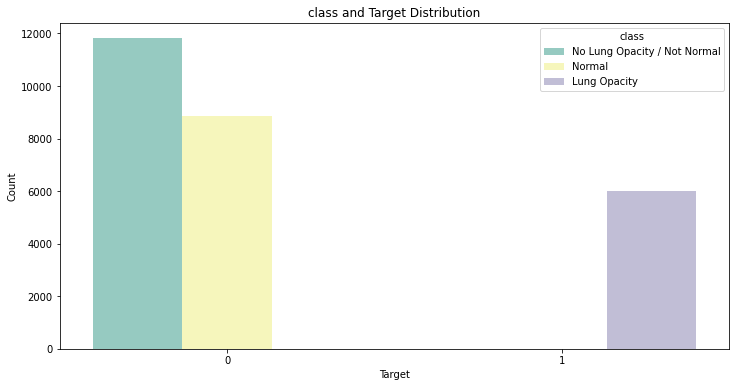

In [59]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Count': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Count',hue='class',data=df, palette='Set3')
plt.title("class and Target Distribution")
plt.show()

Target = 1 associated with class Lung Opacity and
Traget = 0 associated with class Normal and class: No Lung Opacity / Not Normal

**We can see class Lung Opacity entries are less, so we need to do down sampling or upsampling of image data for better model accuracy.**

**Lets explore DICOM images information**

In [60]:
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join(PATH,"stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

We can see some useful data attributes from DICOM image metadata with values Like: sex, age, Body Part Examined, Rows, Columns etc

Lets visualise sample images

**Plot DICOM images with Target = 1 we use mutiple bounding mask data set and non duplicate final dataset separatly to see the images and bounding boxes imposed.**

In [61]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(len(data)//3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

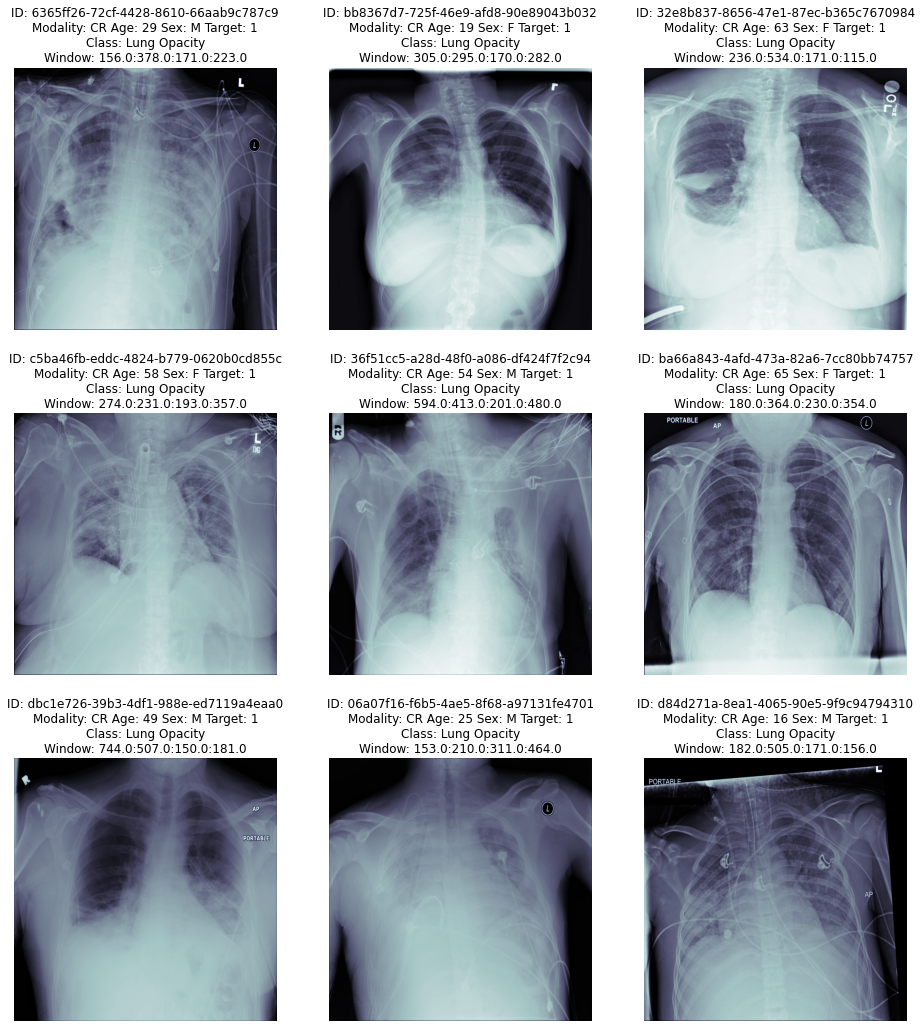

In [62]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

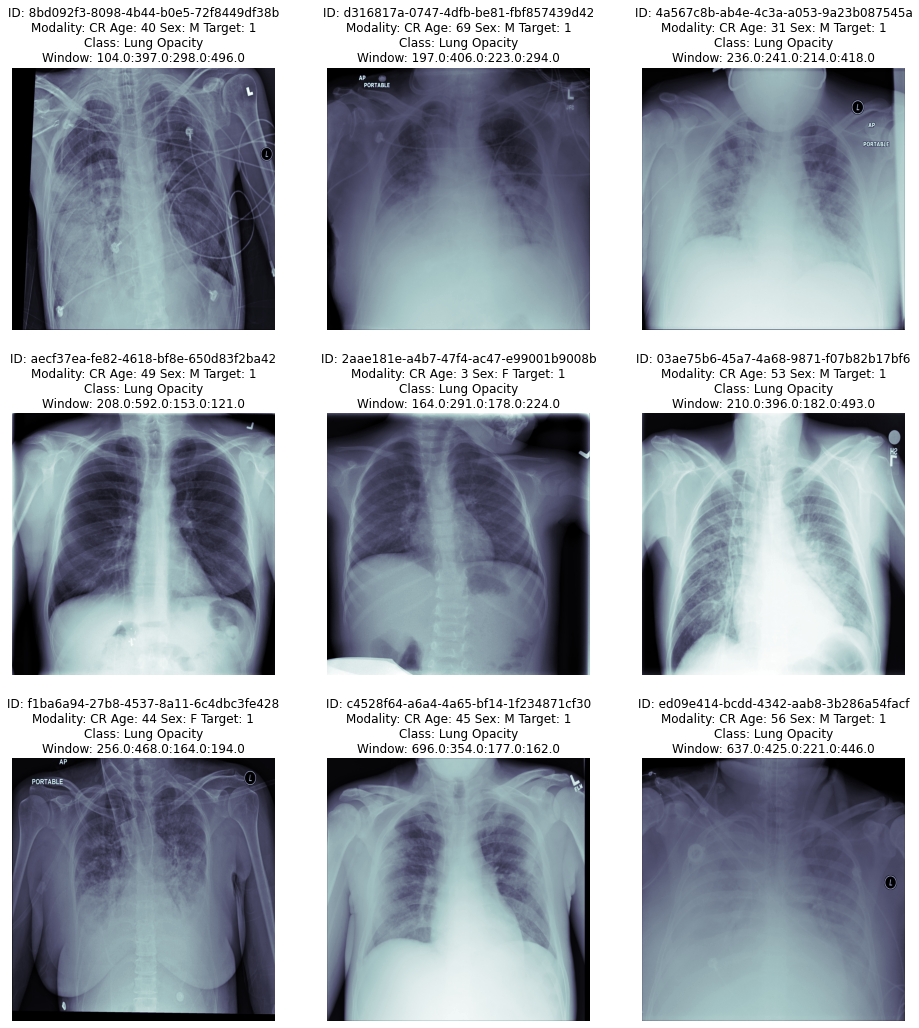

In [63]:
show_dicom_images(train_class_df1[train_class_df1['Target']==1].sample(9))

Lets superpose the bounding boxes by gathering all coordinates of the windows showing Lung Opacity on the same images.

In [64]:
def show_dicom_images_with_boxes(data_df, data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(len(data)//3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = data_df[data_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'],
                        linewidth=4,edgecolor='r',facecolor='none', 
                        color="red",alpha = 0.3))   
    plt.show()

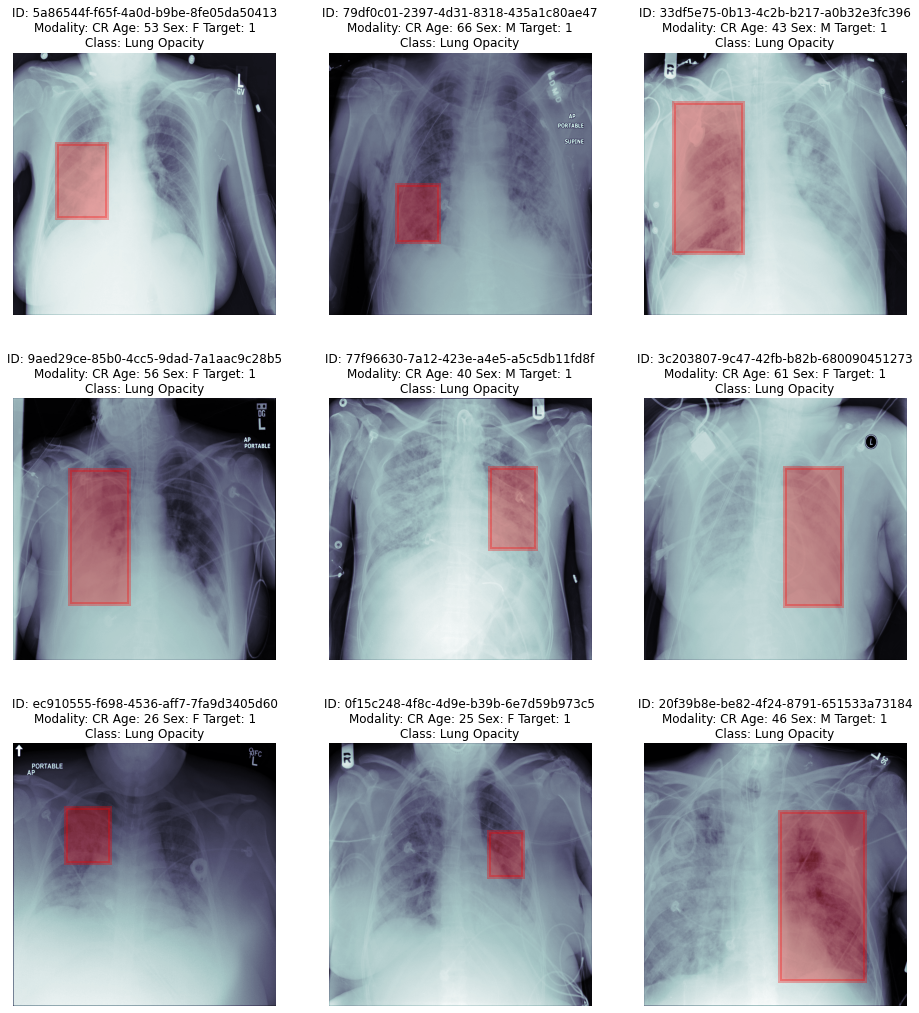

In [65]:
show_dicom_images_with_boxes(train_class_df, train_class_df[train_class_df['Target']==1].sample(9))

In [66]:
duplicate_ids = train_class_df1['patientId'].duplicated(keep=False)
print("Any duplicate data in train_class_df1::",duplicate_ids.any())
if duplicate_ids.any():
    print(train_class_df1[duplicate_ids])

Any duplicate data in train_class_df1:: True
                                  patientId         class      x      y  \
4      00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity  264.0  152.0   
5      00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity  562.0  152.0   
8      00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity  323.0  577.0   
9      00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity  695.0  575.0   
14     00aecb01-a116-45a2-956c-08d2fa55433f  Lung Opacity  288.0  322.0   
...                                     ...           ...    ...    ...   
30220  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2  Lung Opacity  316.0  504.0   
30221  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  Lung Opacity  609.0  464.0   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  Lung Opacity  185.0  298.0   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  570.0  393.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity  233.0  424.0   

       width  height  Target  
4      213.0   379.0   

In [67]:
#train_class_df1[duplicate_ids].sample(9)

dfssample = train_class_df1.groupby('patientId').filter(lambda x: len(x) > 2)

In [68]:
dfssample.shape

(409, 7)

In [69]:
dfssample[dfssample['Target']==1].sample(9)

patientId         class      x      y  \
2497   32408669-c137-4e8d-bd62-fe8345b40e73  Lung Opacity  300.0  367.0   
2363   31764d54-ea3b-434f-bae2-8c579ed13799  Lung Opacity  713.0  593.0   
2311   30d3d2f9-4342-4ab4-9032-34d894c2cfbb  Lung Opacity  673.0  522.0   
2467   3218b157-1f46-4da3-863f-9b97ae22308f  Lung Opacity  653.0  698.0   
29546  1c98cf85-1e50-4def-a8e7-6749808339ff  Lung Opacity  635.0  361.0   
19749  b6ab1a11-6558-4f76-bed2-3b169f820be9  Lung Opacity  218.0  364.0   
18201  ac4bf897-0752-4095-9404-1e6ff42a1dfb  Lung Opacity  552.0  610.0   
14702  90cfaf6d-0247-4431-be9b-bca6c060e394  Lung Opacity  197.0  490.0   
29811  2673d0ba-ab94-4aac-8a9f-1599818c2c12  Lung Opacity  629.0  342.0   

       width  height  Target  
2497   226.0   423.0       1  
2363   181.0   130.0       1  
2311    73.0    86.0       1  
2467   256.0   208.0       1  
29546  169.0   223.0       1  
19749  148.0   122.0       1  
18201  189.0   200.0       1  
14702  240.0   228.0       1  
29811  170.0   158.0       1

In [70]:
dfssample[dfssample['patientId'] == '3239951b-6211-4290-b237-3d9ad17176db']

patientId         class      x      y  width  \
2487  3239951b-6211-4290-b237-3d9ad17176db  Lung Opacity  511.0  249.0  188.0   
2488  3239951b-6211-4290-b237-3d9ad17176db  Lung Opacity  558.0  649.0  174.0   
2489  3239951b-6211-4290-b237-3d9ad17176db  Lung Opacity  152.0  661.0  191.0   
2490  3239951b-6211-4290-b237-3d9ad17176db  Lung Opacity  198.0  370.0  204.0   

      height  Target  
2487   232.0       1  
2488   186.0       1  
2489   145.0       1  
2490   205.0       1

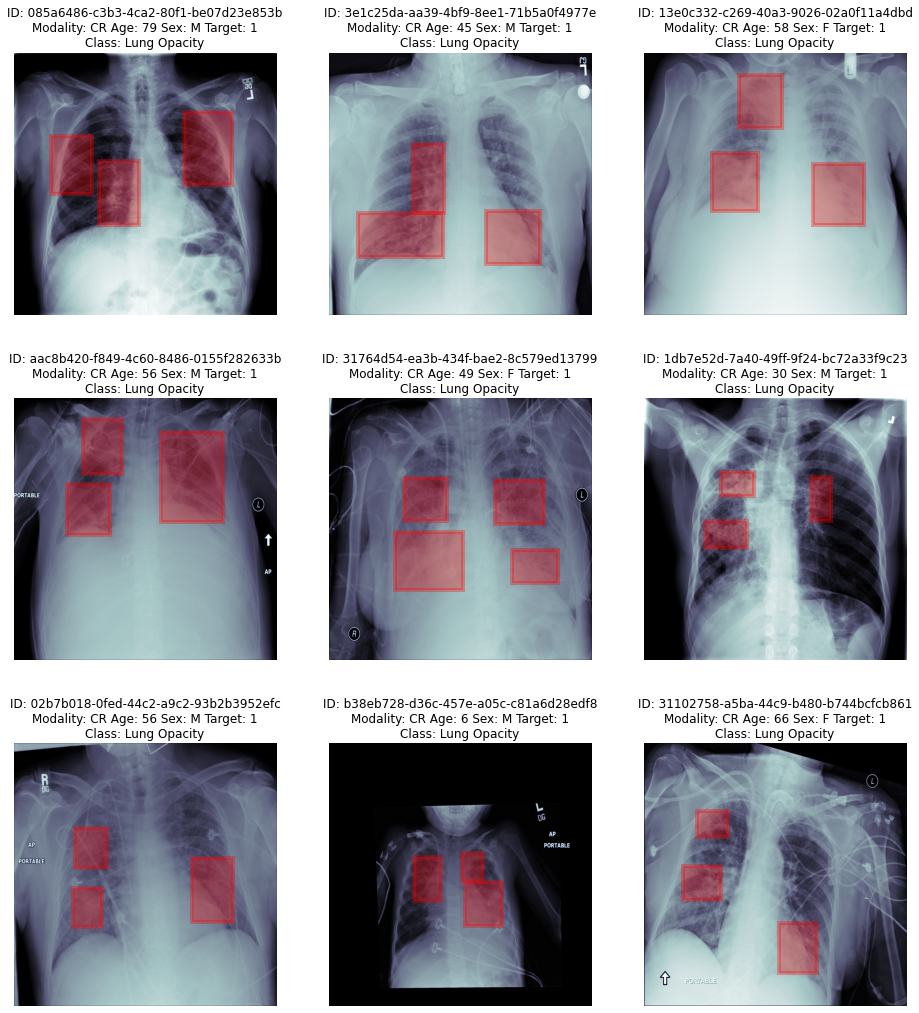

In [71]:
#show_dicom_images_with_boxes(train_class_df1[train_class_df1['Target']==1].sample(9))
show_dicom_images_with_boxes(dfssample, dfssample[dfssample['Target']==1].sample(9))

With multiple bouding boxes We can see multiple highlighted areas for some of the images with Lung Opacity.

Lets sample few normal or Target=0 images

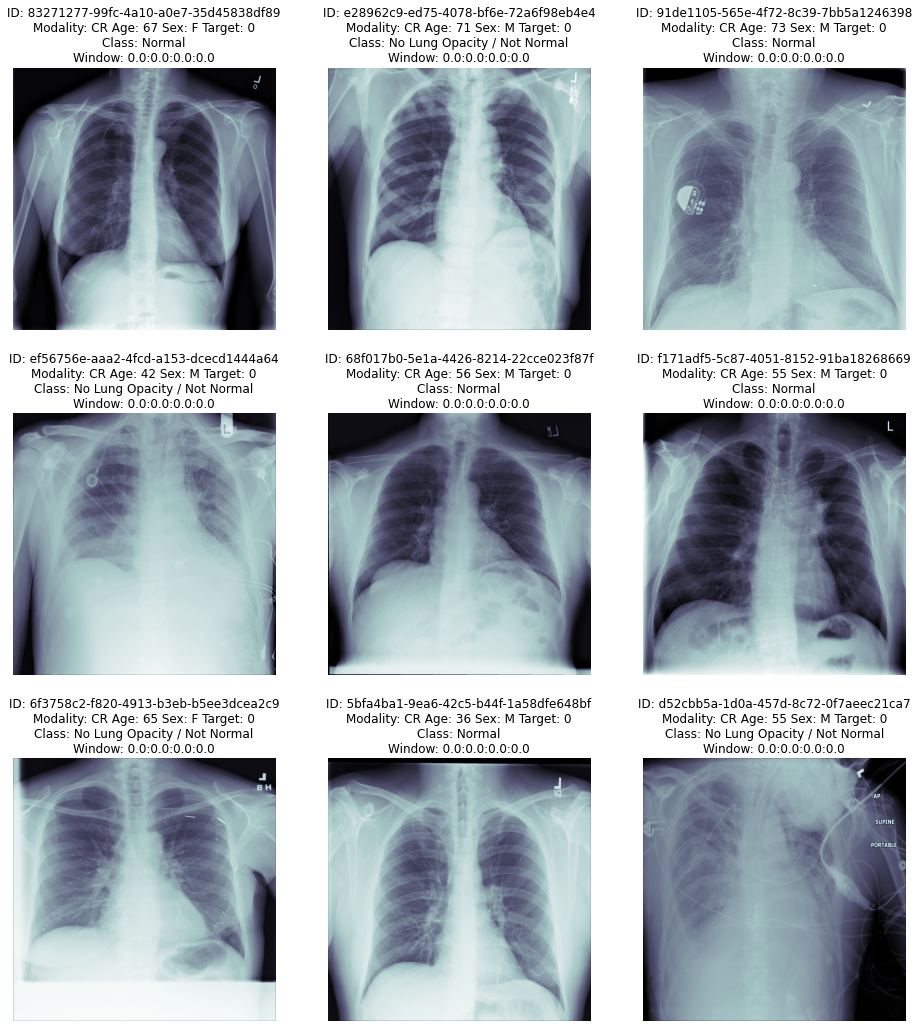

In [72]:
show_dicom_images(train_class_df[train_class_df['Target']==0].sample(9))

Lets add DICOM information for each image to datasets with selected metadata information.

In [73]:
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(PATH+data_path)
    for i, img_name in tqdm(enumerate(image_names)):
        imagePath = os.path.join(PATH,data_path,img_name)
        data_row_img_data = dcm.read_file(imagePath)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
        data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0]) 

In [74]:
process_dicom_data(train_class_df,'stage_2_train_images/')

In [75]:
process_dicom_data(train_class_df1,'stage_2_train_images/')

In [76]:
train_class_df1.shape

(30227, 16)

In [77]:
train_class_df[train_class_df['patientId']=="fffb2395-8edd-4954-8a89-ffe2fd329be3"]

patientId         class      x      y  \
28984  fffb2395-8edd-4954-8a89-ffe2fd329be3  Lung Opacity  641.0  473.0   

       width  height  Target Modality  PatientAge PatientSex BodyPartExamined  \
28984  201.0   309.0       1       CR          46          M            CHEST   

      ViewPosition ConversionType  Rows  Columns PixelSpacing  
28984           AP            WSD  1024     1024        0.168

In [78]:
train_class_df1[train_class_df1['patientId']=="fffb2395-8edd-4954-8a89-ffe2fd329be3"]

patientId         class      x      y  \
28983  fffb2395-8edd-4954-8a89-ffe2fd329be3  Lung Opacity  177.0  285.0   
28984  fffb2395-8edd-4954-8a89-ffe2fd329be3  Lung Opacity  641.0  473.0   

       width  height  Target Modality  PatientAge PatientSex BodyPartExamined  \
28983  225.0   529.0       1       CR          46          M            CHEST   
28984  201.0   309.0       1       CR          46          M            CHEST   

      ViewPosition ConversionType  Rows  Columns PixelSpacing  
28983           AP            WSD  1024     1024        0.168  
28984           AP            WSD  1024     1024        0.168

Lets save final data sets to CSV files, so that we can reuse next time.

In [92]:
train_class_df.to_csv('/kaggle/working/train_class_df.csv', encoding='utf-8', index=False)

In [93]:
train_class_df1.to_csv('/kaggle/working/train_class_df1.csv', encoding='utf-8', index=False)

Lets create test data

**Lets Do EDA on DICOM Image metadata**

View Position is likely important since it describes the positioning of the patient when the radiograph is taken.

Note: I dont have any experience on Medical domain, analysis which is noted here is my own understanding based on data over view.

In [94]:
print("View Position: train:",train_class_df['ViewPosition'].unique())

View Position: train: ['PA' 'AP']


In [95]:
train_class_df['ViewPosition'].value_counts()

PA    14511
AP    12173
Name: ViewPosition, dtype: int64

In [96]:
train_class_df1['ViewPosition'].value_counts()

AP    15297
PA    14930
Name: ViewPosition, dtype: int64

Lets see the data distribution with ViewPosition attribute

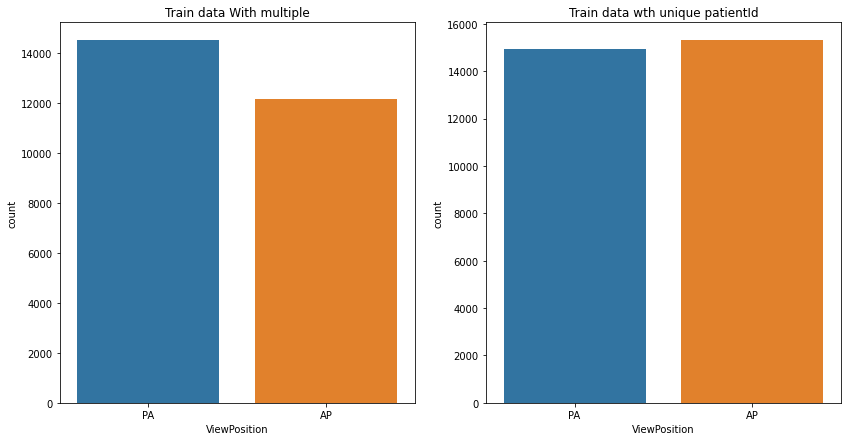

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.countplot(x='ViewPosition', data=train_class_df1, ax=axes[1])
_ = p.set_title('Train data wth unique patientId')

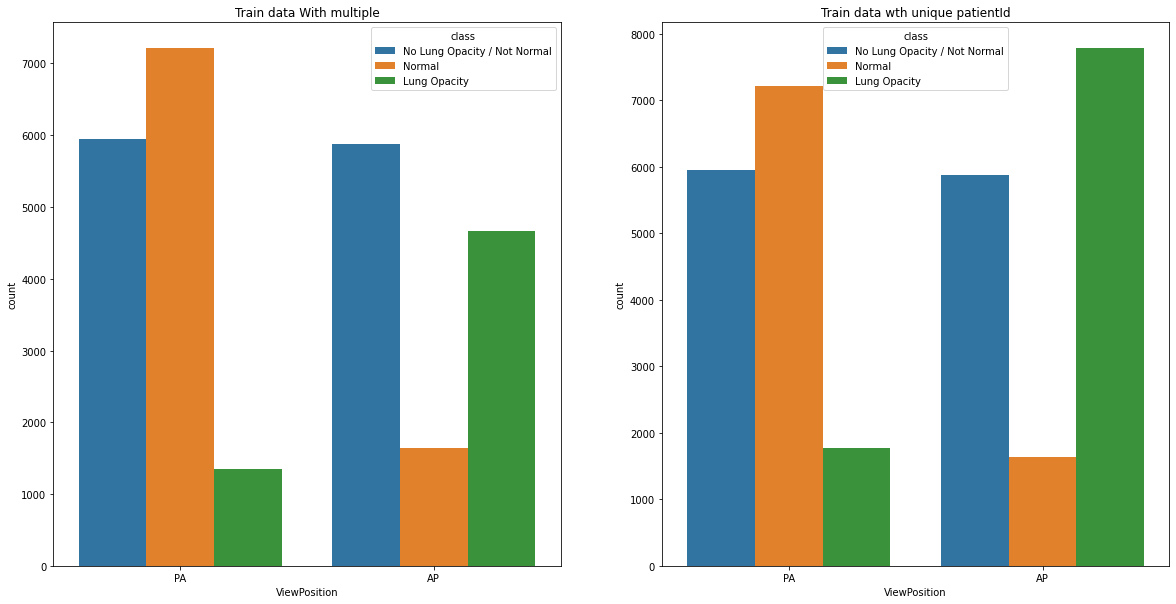

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
p = sns.countplot(x='ViewPosition', hue='class', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.countplot(x='ViewPosition', hue='class', data=train_class_df1, ax=axes[1])
_ = p.set_title('Train data wth unique patientId')

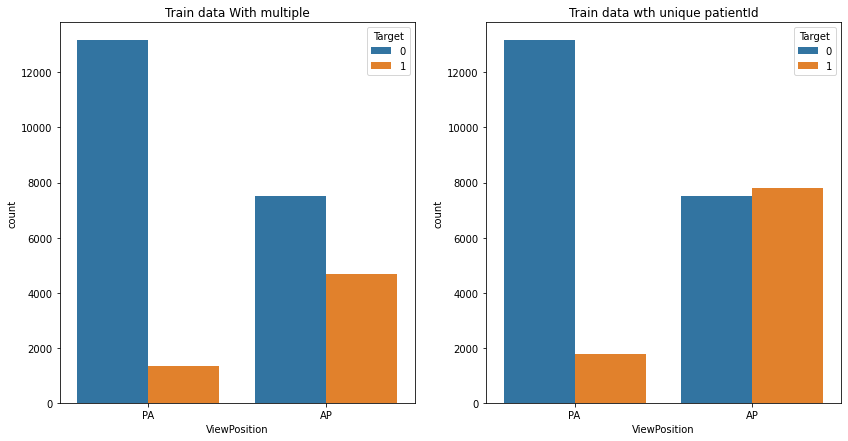

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='Target', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.countplot(x='ViewPosition', hue='Target', data=train_class_df1, ax=axes[1])
_ = p.set_title('Train data wth unique patientId')

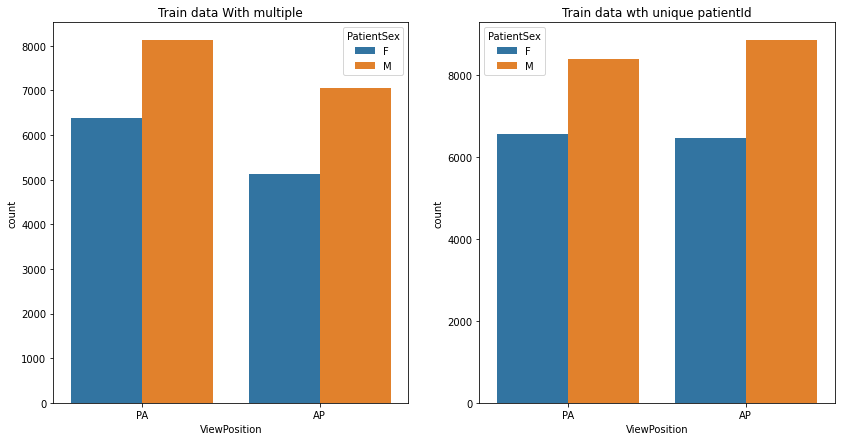

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='PatientSex', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.countplot(x='ViewPosition', hue='PatientSex', data=train_class_df1, ax=axes[1])
_ = p.set_title('Train data wth unique patientId')

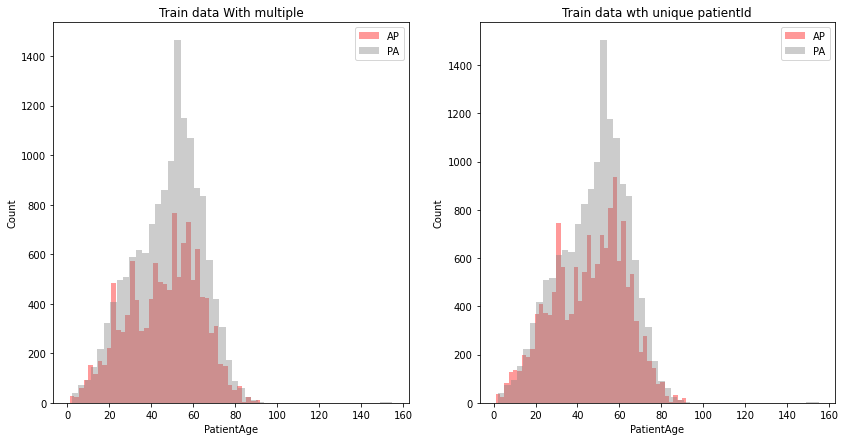

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(train_class_df[train_class_df['ViewPosition']=='AP']['PatientAge'], hist=True, kde=False, color='red', label='AP', ax=axes[0])
p = sns.distplot(train_class_df[train_class_df['ViewPosition']=='PA']['PatientAge'], hist=True, kde=False, color='gray', label='PA', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Train data With multiple')

p = sns.distplot(train_class_df1[train_class_df1['ViewPosition']=='AP']['PatientAge'], hist=True, kde=False, color='red', label='AP', ax=axes[1])
p = sns.distplot(train_class_df1[train_class_df1['ViewPosition']=='PA']['PatientAge'], hist=True, kde=False, color='gray', label='PA', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Train data wth unique patientId')

Lets see the PatientAge distribution

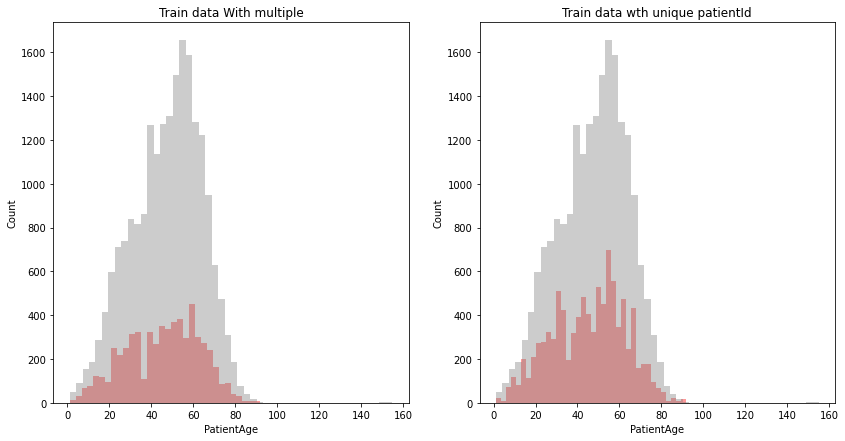

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(train_class_df[train_class_df['Target']==1]['PatientAge'], hist=True, kde=False, color='red', label='Target 1', ax=axes[0])
p = sns.distplot(train_class_df[train_class_df['Target']==0]['PatientAge'], hist=True, kde=False, color='gray', label='Target 0', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.set_title('Train data With multiple')

p = sns.distplot(train_class_df1[train_class_df1['Target']==1]['PatientAge'], hist=True, kde=False, color='red', label='Target 1', ax=axes[1])
p = sns.distplot(train_class_df1[train_class_df1['Target']==0]['PatientAge'], hist=True, kde=False, color='gray', label='Target 0', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.set_title('Train data wth unique patientId')

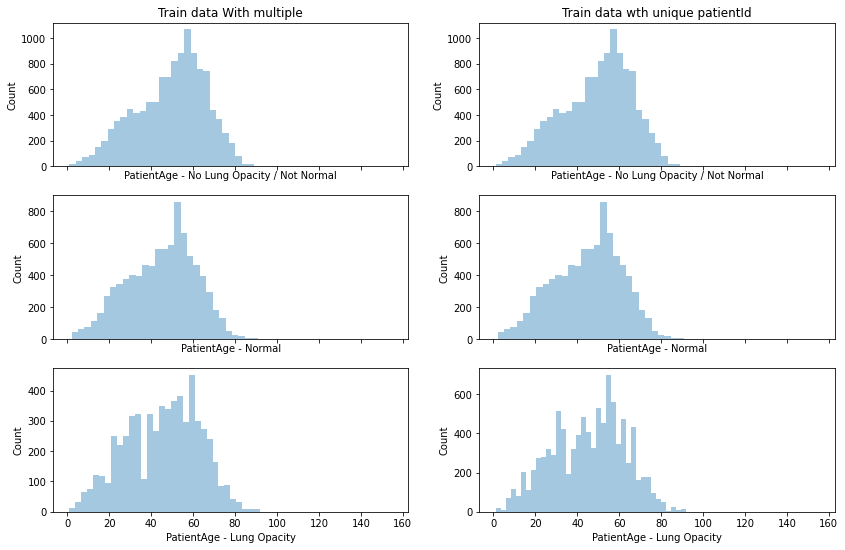

In [103]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)
for i, _class in enumerate(train_class_df['class'].dropna().unique()):
    p = sns.distplot(train_class_df[train_class_df['class']==_class]['PatientAge'], hist=True, kde=False, ax=axes[i, 0])
    _ = p.set_ylabel('Count')
    _ = p.set_xlabel(f'PatientAge - {_class}')
    if i == 0: p.set_title('Train data With multiple')
    
    p = sns.distplot(train_class_df1[train_class_df1['class']==_class]['PatientAge'], hist=True, kde=False, ax=axes[i, 1])
    _ = p.set_ylabel('Count')
    _ = p.set_xlabel(f'PatientAge - {_class}')
    if i == 0: p.set_title('Train data wth unique patientId')

Lets see the PatientSex data distribution

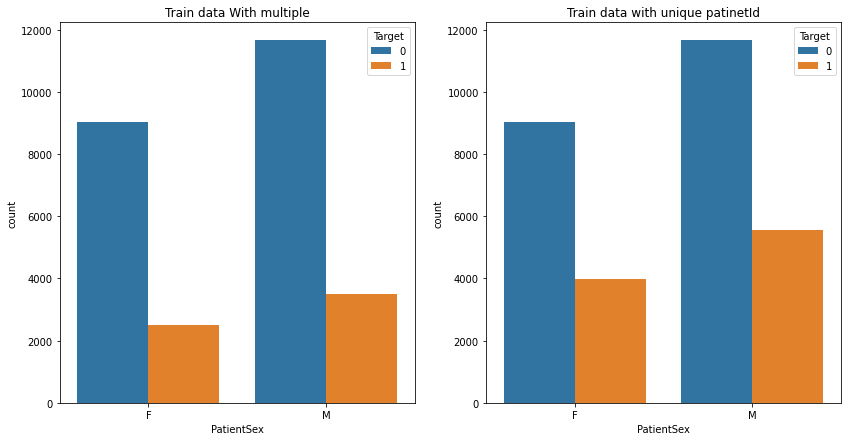

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='PatientSex', hue='Target', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.countplot(x='PatientSex', hue='Target', data=train_class_df1, ax=axes[1])
_ = p.set_title('Train data with unique patinetId')

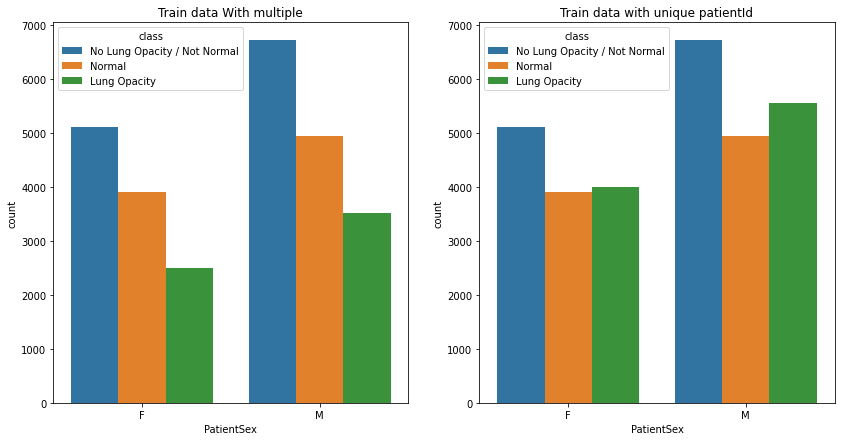

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='PatientSex', hue='class', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.countplot(x='PatientSex', hue='class', data=train_class_df1, ax=axes[1])
_ = p.set_title('Train data with unique patientId')

**Lets check any out layers in the train data set**

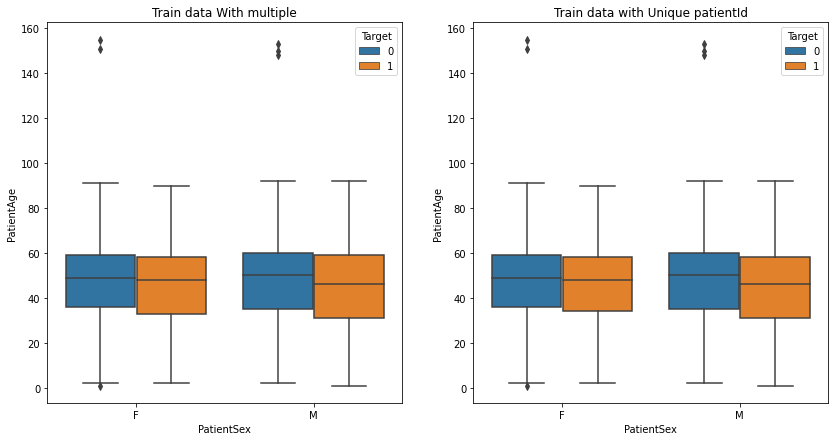

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='Target', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='Target', data=train_class_df1, ax=axes[1])
_ = p.set_title('Train data with Unique patientId')

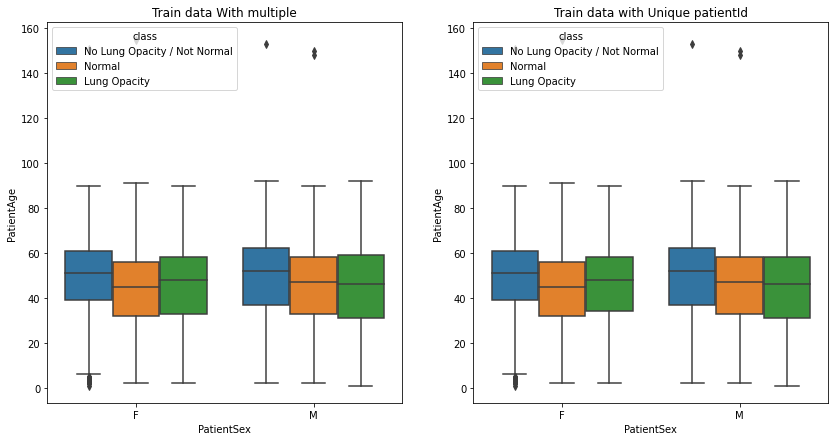

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='class', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='class', data=train_class_df1, ax=axes[1])
_ = p.set_title('Train data with Unique patientId')

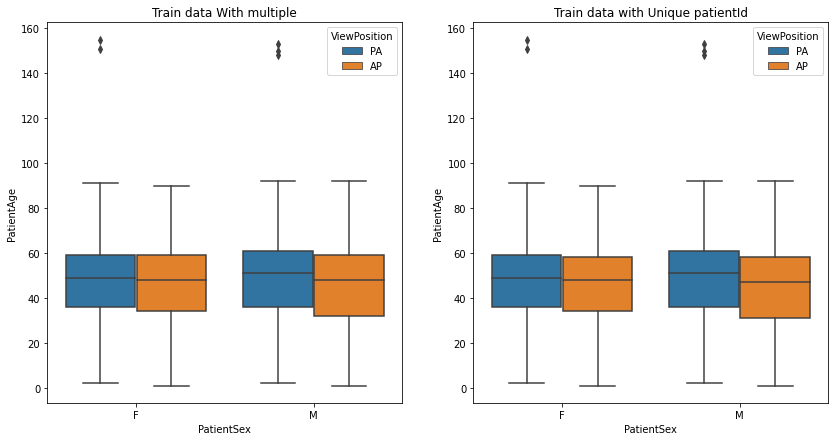

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='ViewPosition', data=train_class_df, ax=axes[0])
_ = p.set_title('Train data With multiple')
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='ViewPosition', data=train_class_df1, ax=axes[1])
_ = p.set_title('Train data with Unique patientId')

We can see there are out layers in the data, **do we need to drop out layer data ? our target to indentify the Pneumonia so other parameters from DIACOM images are not important here, as we will not use DIACOM Image parameters for model training**

**Lets create CNN models with unqiue dataset train_class_df**